### Import Libraries

In [ ]:
pip install imbalanced-learn transformers torch scikit-learn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

### Read the test and train dataset from the checkpoint

In [2]:
train_df = pd.read_csv("../data/train_dataset.csv")

In [3]:
train_df.shape

(7269, 9)

## Data Preprocessing

In [4]:
# Get unique count of values in each column
unique_counts = train_df.apply(lambda x: x.nunique())
print("\nUnique Value Counts:")
print(unique_counts)


Unique Value Counts:
project_name                      7210
methodology_or_protocol            359
region                              13
voluntary_registry                   4
project_type_from_the_registry     106
project_developer                 2572
arborwaproject                       4
scope                                9
type                                78
dtype: int64


In [5]:
# Step 1: Identify duplicate project names
duplicate_projects = train_df[train_df.duplicated('project_name', keep=False)]
duplicate_projects

,project_name,methodology_or_protocol,region,voluntary_registry,project_type_from_the_registry,project_developer,arborwaproject,scope,type
31,Two Fiets Digester,CAR U.S. Livestock Protocol,North America,CAR,Livestock Gas Capture/Combustion,"Maas Energy Works, Inc.",No,Agriculture,Manure Methane Digester
82,Usak Wind Power Plant,ACM0002,Western Asia,VCS,Energy industries (renewable/non-renewable sou...,Aydem Yenilenebilir Enerji A.Ş.,No,Renewable Energy,Wind
127,Coolgas 2019-2,ARB Compliance Offset Protocol: Destruction of...,North America,ACR,Ozone Depleting Substances,A-Gas US Inc.,Compliance,Chemical Processes,Ozone Depleting Substances Recovery & Destruction
138,SPI Wildfire Reforestation Project #3,ARB Compliance Offset Protocol: U.S. Forest Pr...,North America,CAR,Reforestation - ARB Compliance,Sierra Pacific Industries,Compliance,Forestry & Land Use,Afforestation/Reforestation
147,Corinth Abandoned Mine Methane Recovery Project,ARB Compliance Offset Protocol: Mine Methane C...,North America,ACR,Coal Mine Methane,Keyrock Energy LLC,Compliance,Industrial & Commercial,Mine Methane Capture
...,...,...,...,...,...,...,...,...,...
6825,9 MW Wind Energy Farm at Jodhpur Rajasthan by HZL,AMS-I.D.,Southern Asia,VCS,Energy industries (renewable/non-renewable sou...,Hindustan Zinc Limited,No,Renewable Energy,Wind
6940,Finite Carbon - Brosnan Forest,ARB Compliance Offset Protocol: U.S. Forest Pr...,North America,CAR,Improved Forest Management - ARB Compliance,Norfolk Southern Railway Company,Compliance,Forestry & Land Use,Improved Forest Management
6951,Robeson County Landfill,ACM0001,North America,VCS,Waste handling and disposal,"3Degrees Group, Inc",No,Waste Management,Landfill Methane
7021,Alliance Dairy,CAR U.S. Livestock Protocol,North America,CAR,Livestock Gas Capture/Combustion,"3Degrees Group, Inc",No,Agriculture,Manure Methane Digester


In [6]:
duplicate_projects.shape

(117, 9)

### SMOTE to handle Data Imbalance of minority classes

## Identify the outliers from projectTypes

In [7]:

type_df = train_df["type"]
type_counts = type_df.value_counts().reset_index()
type_counts.columns = ["type", 'count']

type_counts


,type,count
0,Cookstoves,1166
1,Wind,831
2,Improved Forest Management,597
3,Hydropower,419
4,Afforestation/Reforestation,374
...,...,...
73,Improved irrigation management,1
74,Pneumatic Retrofit,1
75,Compost Addition to Rangeland,1
76,Grid Expansion & Mini-Grids,1


In [8]:
# Using ZScore to identify the outliers
from scipy.stats import zscore
# Calculate Z-scores for counts
type_counts['zscore'] = zscore(type_counts['count'])

# Identify outliers (e.g., Z-score > 2 or Z-score < -2)
outliers = type_counts[np.abs(type_counts['zscore']) > 2]

print("Outliers based on Z-score:")
print(outliers)

Outliers based on Z-score:
                         type  count    zscore
0                  Cookstoves   1166  5.659761
1                        Wind    831  3.892417
2  Improved Forest Management    597  2.657914


In [9]:
# Projects with types lower than 10 counts
type_counts = train_df["type"].value_counts()

# Identify the types with fewer than 10 counts
types_to_drop = type_counts[type_counts < 10].index
print(types_to_drop.shape)
# Drop the records with these types from train_df
train_df_new = train_df[~train_df["type"].isin(types_to_drop)]
print(train_df_new.shape)

(32,)
(7148, 9)


In [10]:
# Based on the Zscore, the major classes will be undersampled and minority classes will be oversample

In [11]:
X_train_df = train_df_new.drop(columns=['type', 'scope'])
Y_train_df = train_df_new['type']

In [12]:
print(X_train_df.shape)

(7148, 7)


In [13]:
## Splitting the train to train and validation sets
X_train, X_val, Y_train, Y_val  = train_test_split(X_train_df,Y_train_df, test_size=0.1, stratify =Y_train_df,  random_state=42)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape )

(6433, 7) (715, 7) (6433,) (715,)


## Encoding the categorical and text features


In [14]:
# Define categorical and text features
categorical_features = ['region', 'voluntary_registry', 'arborwaproject']
text_features = ['project_name','methodology_or_protocol','project_type_from_the_registry', 'project_developer']


In [16]:
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Preprocessor for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessor for text features
text_transformers = [(f'text_{i}', TfidfVectorizer(), col) for i, col in enumerate(text_features)]

# Combine all preprocessors into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ] + text_transformers,
    remainder='passthrough'
)

# Define SMOTE and RandomUnderSampler
over_sampling = SMOTE(random_state=42)
sampling_strategy = {
    'Cookstoves': 800#,  
    #'Wind': 800 #         
    #'Improved Forest Management': 300 
}
under_sampling = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)

# Pipeline for preprocessing and resampling
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('undersampling', under_sampling),
    ('oversampling', over_sampling)
])

# Apply preprocessing, SMOTE, and undersampling
X_resampled_combined, y_resampled = pipeline.fit_resample(X_train, Y_train)


In [17]:
print(X_resampled_combined.shape, y_resampled.shape)
print(X_resampled_combined.dtype)

(36800, 11309) (36800,)
float64


In [18]:
# Check the class distribution after resampling
resampledCounter = Counter(y_resampled)
originalCounter = Counter(Y_train_df)

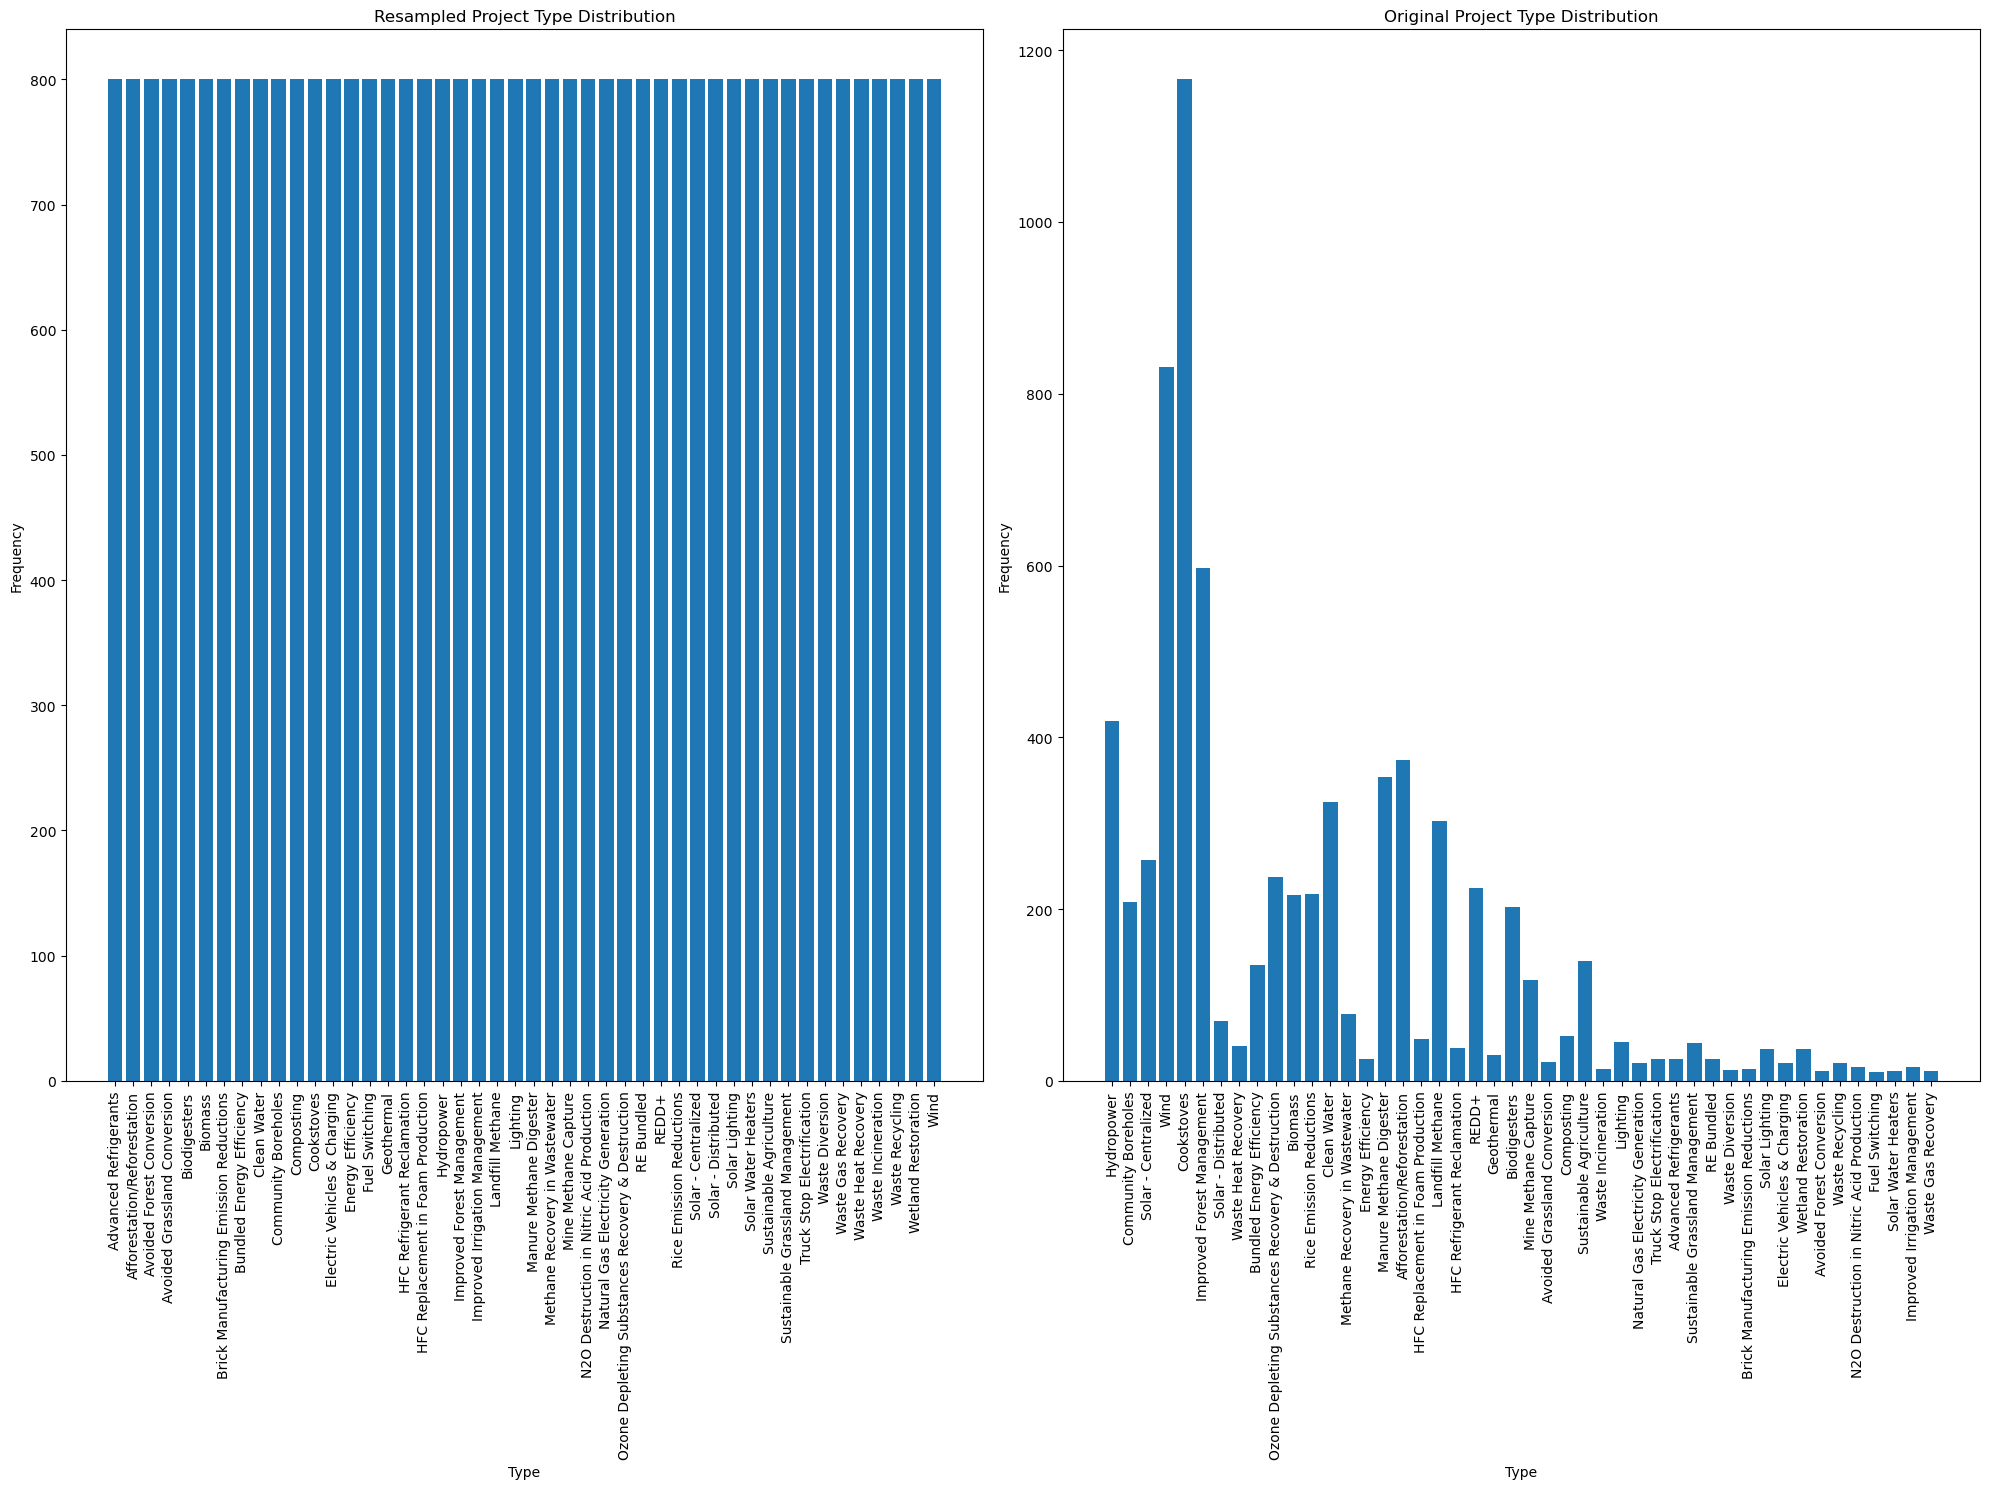

In [19]:
# Plotting histograms
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 15))

# Resampled class distribution histogram
axes[0].bar(resampledCounter.keys(), resampledCounter.values())
axes[0].set_title('Resampled Project Type Distribution')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(list(resampledCounter.keys()))
axes[0].set_xticklabels(resampledCounter.keys(), rotation=90)

# Original class distribution histogram
axes[1].bar(originalCounter.keys(), originalCounter.values())
axes[1].set_title('Original Project Type Distribution')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(list(originalCounter.keys()))
axes[1].set_xticklabels(originalCounter.keys(), rotation=90)

# Display the histograms
plt.tight_layout()
plt.show()


### Logistic Regression

In [25]:
# Define the logistic regression model
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

# Fit the logistic regression model on the resampled data
logistic_regression.fit(X_resampled_combined, y_resampled)


LogisticRegression(max_iter=1000, random_state=42)

In [26]:
# Make predictions on the val data

X_val_transformed = preprocessor.transform(X_val)
y_pred = logistic_regression.predict(X_val_transformed)

# Evaluate the model and get the classification report
report = classification_report(Y_val, y_pred, output_dict=True)

# Convert the classification report to a DataFrame for a tabular format
report_df = pd.DataFrame(report).transpose()

# Display the classification report table
report_df

/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/shrikantwaghmare/miniconda3/envs/w266/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

,precision,recall,f1-score,support
Advanced Refrigerants,1.000000,1.000000,1.000000,3.00000
Afforestation/Reforestation,1.000000,0.972973,0.986301,37.00000
Avoided Forest Conversion,1.000000,1.000000,1.000000,1.00000
Avoided Grassland Conversion,1.000000,1.000000,1.000000,2.00000
Biodigesters,0.950000,0.950000,0.950000,20.00000
Biomass,0.857143,0.818182,0.837209,22.00000
Brick Manufacturing Emission Reductions,0.500000,1.000000,0.666667,1.00000
Bundled Energy Efficiency,0.785714,0.785714,0.785714,14.00000
Clean Water,0.939394,0.939394,0.939394,33.00000
Community Boreholes,0.913043,1.000000,0.954545,21.00000


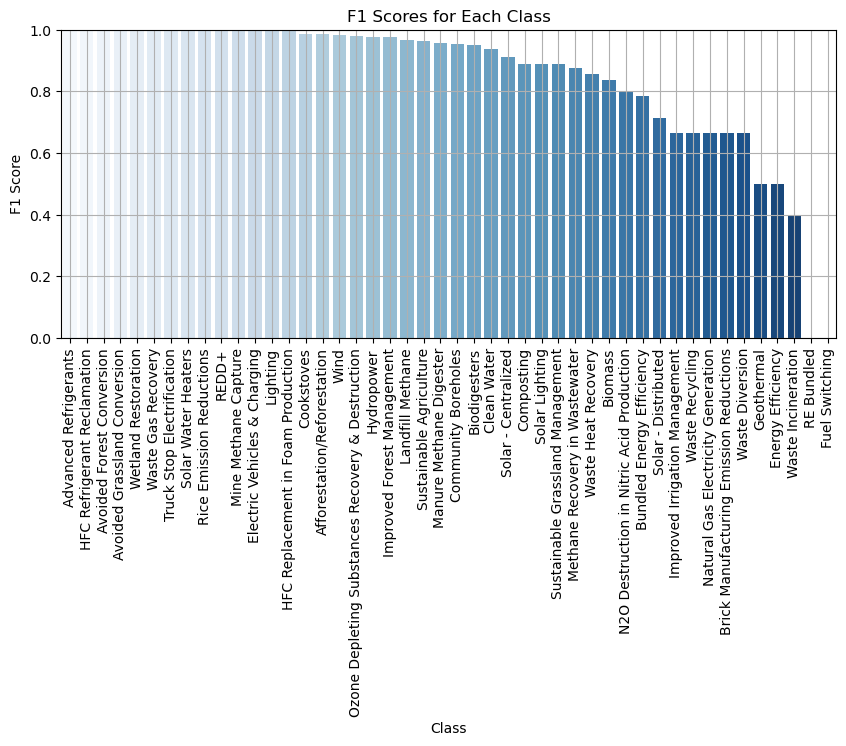

In [27]:
import seaborn as sns
# Extract F1 scores from the classification report
f1_scores = {key: value['f1-score'] for key, value in report.items() if key not in ('accuracy', 'macro avg', 'weighted avg')}

# Convert the F1 scores to a DataFrame for plotting
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Class', 'F1 Score'])

# Sort the DataFrame by F1 Score in ascending order
f1_df = f1_df.sort_values(by='F1 Score', ascending = False)

# Plot the F1 scores
plt.figure(figsize=(10, 4))
sns.barplot(x='Class', y='F1 Score', data=f1_df, palette='Blues')
plt.title('F1 Scores for Each Class')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=90)  # Rotate x-ticks by 90 degrees
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# Generate the confusion matrix
cm = confusion_matrix(Y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_regression.classes_)
fig, ax = plt.subplots(figsize=(25, 25))  
disp.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=90)  # Rotate the x-axis labels if they overlap
plt.show()

In [ ]:
# Understanding the REBundled and Fuel switching data
REBundled = train_df_new[train_df_new['type'] == 'RE Bundled']
print(REBundled.shape)
REBundled